In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import timm

In [ ]:
model_names = timm.list_models(pretrained=True)
models= [name for name in model_names if 'efficientnetv2' in name]
models

['efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k',
 'gc_efficientnetv2_rw_t.agc_in1k',
 'tf_efficientnetv2_b0.in1k',
 'tf_efficientnetv2_b1.in1k',
 'tf_efficientnetv2_b2.in1k',
 'tf_efficientnetv2_b3.in1k',
 'tf_efficientnetv2_b3.in21k',
 'tf_efficientnetv2_b3.in21k_ft_in1k',
 'tf_efficientnetv2_l.in1k',
 'tf_efficientnetv2_l.in21k',
 'tf_efficientnetv2_l.in21k_ft_in1k',
 'tf_efficientnetv2_m.in1k',
 'tf_efficientnetv2_m.in21k',
 'tf_efficientnetv2_m.in21k_ft_in1k',
 'tf_efficientnetv2_s.in1k',
 'tf_efficientnetv2_s.in21k',
 'tf_efficientnetv2_s.in21k_ft_in1k',
 'tf_efficientnetv2_xl.in21k',
 'tf_efficientnetv2_xl.in21k_ft_in1k']

- EfficientNetV2-b0

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.0001
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

# Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Train and Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# EfficientNetV2 B0 Model
class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize Model, Optimizer, Loss Function, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2B0(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=10)
    train_acc_history, val_acc_history, val_loss_history, train_loss_history = [], [], [],[]

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)
        train_loss = running_loss / len(train_loader)  # Average training loss
        train_loss_history.append(train_loss)

        # Validation Step
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_preds == val_labels).sum().item()

        val_acc = correct_val / total_val
        val_loss /= len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step()

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
    # Save the final model (after training finishes)
    model.load_state_dict(early_stopping.best_model_wts)
    torch.save(model.state_dict(), 'final_model.pth')

    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history

# Train the model
trained_model, train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

Epoch 1/50, Train Acc: 0.2000, Val Acc: 0.3500, Val Loss: 1.9964
Epoch 2/50, Train Acc: 0.4016, Val Acc: 0.4562, Val Loss: 1.9297
Epoch 3/50, Train Acc: 0.5734, Val Acc: 0.5687, Val Loss: 1.8546
Epoch 4/50, Train Acc: 0.7156, Val Acc: 0.6438, Val Loss: 1.7496
Epoch 5/50, Train Acc: 0.7859, Val Acc: 0.6875, Val Loss: 1.6282
Epoch 6/50, Train Acc: 0.8313, Val Acc: 0.6875, Val Loss: 1.4531
Epoch 7/50, Train Acc: 0.8609, Val Acc: 0.7438, Val Loss: 1.2738
Epoch 8/50, Train Acc: 0.8578, Val Acc: 0.7688, Val Loss: 1.0687
Epoch 9/50, Train Acc: 0.8703, Val Acc: 0.8063, Val Loss: 0.8462
Epoch 10/50, Train Acc: 0.9141, Val Acc: 0.8250, Val Loss: 0.6614
Epoch 11/50, Train Acc: 0.9234, Val Acc: 0.8562, Val Loss: 0.5497
Epoch 12/50, Train Acc: 0.9375, Val Acc: 0.8562, Val Loss: 0.4706
Epoch 13/50, Train Acc: 0.9547, Val Acc: 0.8750, Val Loss: 0.4000
Epoch 14/50, Train Acc: 0.9500, Val Acc: 0.9125, Val Loss: 0.3178
Epoch 15/50, Train Acc: 0.9703, Val Acc: 0.8938, Val Loss: 0.3117
Epoch 16/50, Train 

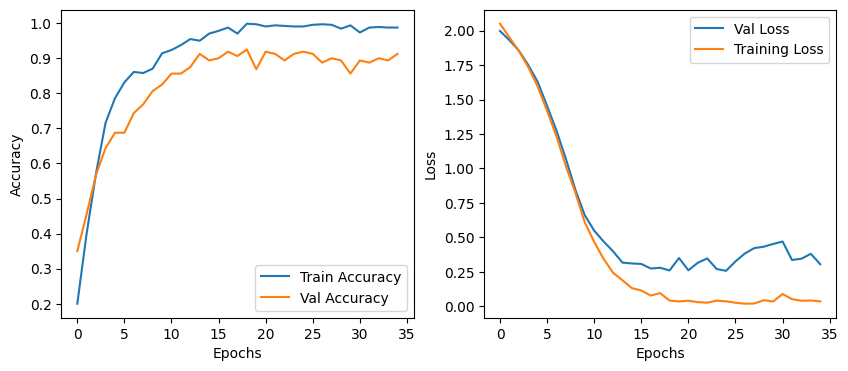

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label='Val Loss')
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Classification Report and Accuracy
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            all_preds.extend(val_preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(report)

# Evaluate model
evaluate_model(trained_model, val_loader)

Overall Accuracy: 90.00%
                       precision    recall  f1-score   support

       female_bodycon       1.00      0.95      0.97        19
 female_pant_suit_top       1.00      0.83      0.91        30
  female_pants_bottom       0.86      0.86      0.86        14
  informal cloths men       0.87      0.95      0.91        21
informal cloths women       0.95      0.86      0.90        21
           male_pants       0.90      0.90      0.90        21
            shirt men       0.76      0.93      0.84        14
            suits men       0.83      0.95      0.88        20

             accuracy                           0.90       160
            macro avg       0.90      0.90      0.90       160
         weighted avg       0.91      0.90      0.90       160



- EfficientNetV3-b2

In [ ]:
# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.001
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

# Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Train and Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# EfficientNetV2 B0 Model
class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b2.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize Model, Optimizer, Loss Function, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2B0(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.1)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=10)
    train_acc_history, val_acc_history, val_loss_history, train_loss_history = [], [], [],[]

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)
        train_loss = running_loss / len(train_loader)  # Average training loss
        train_loss_history.append(train_loss)

        # Validation Step
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_preds == val_labels).sum().item()

        val_acc = correct_val / total_val
        val_loss /= len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Train Loss:{train_loss: .6f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')
        scheduler.step()

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(early_stopping.best_model_wts)
    torch.save(model.state_dict(), 'final_model_b2.pth')
    return model, train_acc_history, val_acc_history, val_loss_history,train_loss_history

# Train the model
trained_model, train_acc_history,train_loss_history, val_acc_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)

Epoch 1/50, Train Acc: 0.2094, Train Loss: 2.045144, Val Acc: 0.2625, Val Loss: 1.9980
Epoch 2/50, Train Acc: 0.4656, Train Loss: 1.918180, Val Acc: 0.5500, Val Loss: 1.9029
Epoch 3/50, Train Acc: 0.6859, Train Loss: 1.798056, Val Acc: 0.5813, Val Loss: 1.7932
Epoch 4/50, Train Acc: 0.7688, Train Loss: 1.646758, Val Acc: 0.6438, Val Loss: 1.6268
Epoch 5/50, Train Acc: 0.8281, Train Loss: 1.457005, Val Acc: 0.7562, Val Loss: 1.4484
Epoch 6/50, Train Acc: 0.8719, Train Loss: 1.225716, Val Acc: 0.7625, Val Loss: 1.2184
Epoch 7/50, Train Acc: 0.8766, Train Loss: 0.989090, Val Acc: 0.8063, Val Loss: 1.0105
Epoch 8/50, Train Acc: 0.8828, Train Loss: 0.750956, Val Acc: 0.8187, Val Loss: 0.7742
Epoch 9/50, Train Acc: 0.9172, Train Loss: 0.558124, Val Acc: 0.8438, Val Loss: 0.6038
Epoch 10/50, Train Acc: 0.9328, Train Loss: 0.403420, Val Acc: 0.8562, Val Loss: 0.4950
Epoch 11/50, Train Acc: 0.9609, Train Loss: 0.262592, Val Acc: 0.8812, Val Loss: 0.4021
Epoch 12/50, Train Acc: 0.9609, Train Los

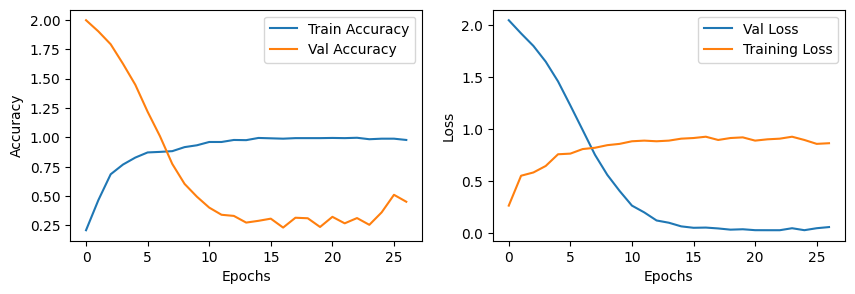

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label='Val Loss')
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Classification Report and Accuracy
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            all_preds.extend(val_preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(report)

# Evaluate model
evaluate_model(trained_model, val_loader)

Overall Accuracy: 86.88%
                       precision    recall  f1-score   support

       female_bodycon       0.95      0.95      0.95        20
 female_pant_suit_top       0.84      0.84      0.84        19
  female_pants_bottom       0.79      0.81      0.80        27
  informal cloths men       0.92      0.79      0.85        14
informal cloths women       1.00      0.91      0.95        22
           male_pants       0.72      0.72      0.72        18
            shirt men       0.87      0.95      0.91        21
            suits men       0.90      0.95      0.92        19

             accuracy                           0.87       160
            macro avg       0.87      0.87      0.87       160
         weighted avg       0.87      0.87      0.87       160



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

# Parameters
img_size = (224, 224)
batch_size = 32
epochs = 50
learning_rate = 0.0001
data_dir = '/content/drive/MyDrive/Clothing_Data_HRP'

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=img_size, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

# Load Dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Train and Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# EfficientNetV2 B0 Model
class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b2.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Dropout(0.5)  # Adding Dropout for regularization
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model, Optimizer, Loss Function, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetV2B0(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_wts = model.state_dict()
            self.counter = 0

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    early_stopping = EarlyStopping(patience=10)
    train_acc_history, val_acc_history, val_loss_history, train_loss_history = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)
        train_loss = running_loss / len(train_loader)  # Average training loss
        train_loss_history.append(train_loss)

        # Validation Step
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()
                _, val_preds = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_preds == val_labels).sum().item()

        val_acc = correct_val / total_val
        val_loss /= len(val_loader)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.6f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(early_stopping.best_model_wts)
    torch.save(model.state_dict(), 'final_model_b2.pth')
    return model, train_acc_history, val_acc_history, val_loss_history, train_loss_history

# Train the model
trained_model, train_acc_history, train_loss_history, val_acc_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/50, Train Acc: 0.1969, Train Loss: 2.026678, Val Acc: 0.4562, Val Loss: 1.9493
Epoch 2/50, Train Acc: 0.3937, Train Loss: 1.842085, Val Acc: 0.6500, Val Loss: 1.7539
Epoch 3/50, Train Acc: 0.4875, Train Loss: 1.588324, Val Acc: 0.7250, Val Loss: 1.4759
Epoch 4/50, Train Acc: 0.5312, Train Loss: 1.340217, Val Acc: 0.8000, Val Loss: 1.1879
Epoch 5/50, Train Acc: 0.5250, Train Loss: 1.242720, Val Acc: 0.8187, Val Loss: 1.0699
Epoch 6/50, Train Acc: 0.5563, Train Loss: 1.096344, Val Acc: 0.8625, Val Loss: 0.8945
Epoch 7/50, Train Acc: 0.5766, Train Loss: 1.030889, Val Acc: 0.8812, Val Loss: 0.7696
Epoch 8/50, Train Acc: 0.5875, Train Loss: 0.980712, Val Acc: 0.8875, Val Loss: 0.6829
Epoch 9/50, Train Acc: 0.6125, Train Loss: 0.878549, Val Acc: 0.8938, Val Loss: 0.6298
Epoch 10/50, Train Acc: 0.6109, Train Loss: 0.884767, Val Acc: 0.8812, Val Loss: 0.5599
Epoch 11/50, Train Acc: 0.6172, Train Loss: 0.883586, Val Acc: 0.8812, Val Loss: 0.5333
Epoch 12/50, Train Acc: 0.6297, Train Los

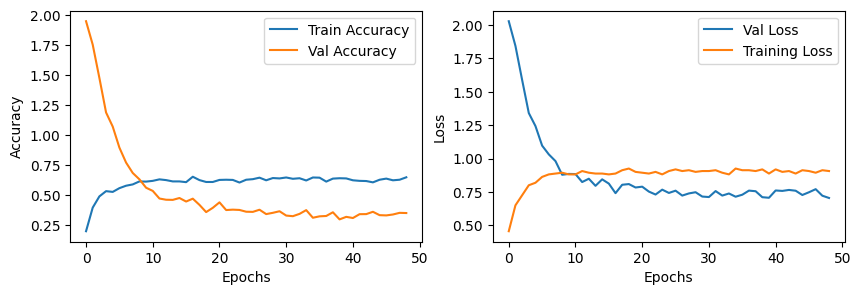

In [ ]:
# Plot accuracy and loss
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_loss_history, label='Val Loss')
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Overall Accuracy: 91.25%
                       precision    recall  f1-score   support

       female_bodycon       1.00      0.94      0.97        18
 female_pant_suit_top       0.90      0.95      0.93        20
  female_pants_bottom       0.82      0.95      0.88        19
  informal cloths men       0.83      0.88      0.86        17
informal cloths women       0.96      0.92      0.94        25
           male_pants       0.96      0.88      0.92        25
            shirt men       0.94      0.85      0.89        20
            suits men       0.88      0.94      0.91        16

             accuracy                           0.91       160
            macro avg       0.91      0.91      0.91       160
         weighted avg       0.92      0.91      0.91       160



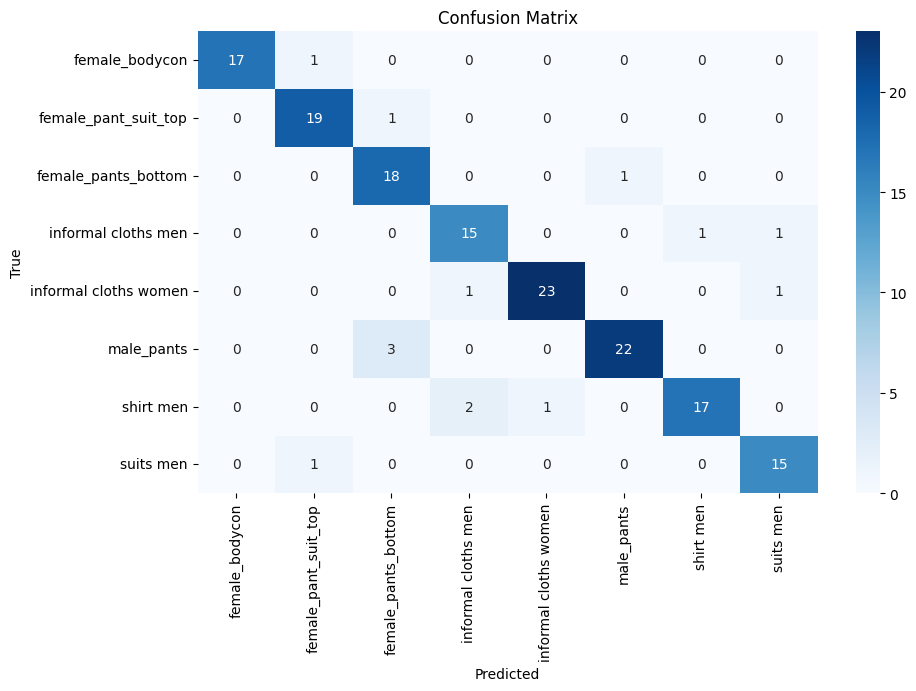

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs, 1)
            all_preds.extend(val_preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(trained_model, val_loader)

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import timm
import torch.nn as nn
import numpy as np

class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b2.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        return self.model(x)

def load_model(model_path, num_classes, device='cpu'):
    """
    Load the trained model
    """
    model = EfficientNetV2B0(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def process_image(image, img_size=(224, 224)):
    """
    Process image for model input
    """
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

def predict_image(model, image_input, class_names, device='cpu'):
    """
    Make prediction for a given image input

    Parameters:
    -----------
    model : torch.nn.Module
        Trained PyTorch model
    image_input : str or PIL.Image or numpy.ndarray
        Can be:
        - Path to image file
        - URL to image
        - PIL Image object
        - Numpy array
    class_names : list
        List of class names
    device : str
        'cpu' or 'cuda' (default: 'cpu')

    Returns:
    --------
    dict
        Dictionary containing predicted class and probabilities
    """
    try:
        # Handle different input types
        if isinstance(image_input, str):
            if image_input.startswith(('http://', 'https://')):
                # Handle URL
                response = requests.get(image_input)
                image = Image.open(BytesIO(response.content)).convert('RGB')
            else:
                # Handle local file path
                image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, np.ndarray):
            # Handle numpy array
            image = Image.fromarray(np.uint8(image_input)).convert('RGB')
        elif isinstance(image_input, Image.Image):
            # Handle PIL Image
            image = image_input.convert('RGB')
        else:
            raise ValueError("Unsupported input type. Please provide either an image path, URL, PIL Image, or numpy array")

        # Process image
        img_tensor = process_image(image).to(device)

        # Get prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            # Get top prediction
            _, predicted = torch.max(outputs.data, 1)

            # Get all probabilities
            probs = probabilities.cpu().numpy()[0]

            # Create results dictionary
            results = {
                'predicted_class': class_names[predicted.item()],
                'confidence': float(probs[predicted.item()]),
                'probabilities': {class_names[i]: float(prob)
                                for i, prob in enumerate(probs)}
            }

            return results

    except Exception as e:
        return {'error': str(e)}

# Example usage function
def inference_example():
    """
    Example of how to use the inference function
    """
    # Model parameters
    model_path = '/content/final_model_b2.pth'  # Path to your saved model
    num_classes = len(dataset.classes)  # Number of classes in your dataset
    class_names = dataset.classes  # List of class names

    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = load_model(model_path, num_classes, device)

    # Example usage with different input types

    # 1. Local image path
    result = predict_image(model, 'path/to/your/image.jpg', class_names, device)
    print("Prediction from local image:", result)

    # 2. Image URL
    url = "https://example.com/image.jpg"
    result = predict_image(model, url, class_names, device)
    print("Prediction from URL:", result)

# Function to get top N predictions
def get_top_n_predictions(model, image_path, class_names, n=3, device='cpu'):
    """
    Get top N predictions for an image
    """
    results = predict_image(model, image_path, class_names, device)
    if 'error' not in results:
        # Sort probabilities by value
        sorted_probs = sorted(results['probabilities'].items(),
                            key=lambda x: x[1],
                            reverse=True)[:n]
        return {
            'top_predictions': [
                {'class': class_name, 'probability': prob}
                for class_name, prob in sorted_probs
            ]
        }
    return results

# Example of how to use the functions
if __name__ == "__main__":
    # Example setup
    model_path = 'final_model_b2.pth'
    num_classes = len(dataset.classes)  # Replace with your number of classes
    class_names = dataset.classes  # Replace with your class names

    # Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    model = load_model(model_path, num_classes, device)

    # Example image path
    image_path = 'path/to/test/image.jpg'

    # Get prediction
    result = predict_image(model, image_path, class_names, device)
    print("\nSingle prediction:")
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.2%}")

    # Get top 3 predictions
    top_3 = get_top_n_predictions(model, image_path, class_names, n=3, device=device)
    print("\nTop 3 predictions:")
    for pred in top_3['top_predictions']:
        print(f"{pred['class']}: {pred['probability']:.2%}")

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import timm
import torch.nn as nn
import numpy as np

class EfficientNetV2B0(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2B0, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b2.in1k', pretrained=True)
        num_ftrs = self.model.get_classifier().in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        return self.model(x)

def load_model(model_path, device='cpu'):
    """
    Load the trained model with the correct number of classes from saved state
    """
    # First load the state dict to get the number of classes
    state_dict = torch.load(model_path, map_location=device)

    # Get the number of classes from the classifier weights
    num_classes = state_dict['model.classifier.0.bias'].size(0)

    # Create model with correct number of classes
    model = EfficientNetV2B0(num_classes=num_classes)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model, num_classes

def process_image(image, img_size=(224, 224)):
    """
    Process image for model input
    """
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

def predict_image(model, image_input, class_names, device='cpu'):
    """
    Make prediction for a given image input
    """
    try:
        # Handle different input types
        if isinstance(image_input, str):
            if image_input.startswith(('http://', 'https://')):
                # Handle URL
                response = requests.get(image_input)
                image = Image.open(BytesIO(response.content)).convert('RGB')
            else:
                # Handle local file path
                image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, np.ndarray):
            # Handle numpy array
            image = Image.fromarray(np.uint8(image_input)).convert('RGB')
        elif isinstance(image_input, Image.Image):
            # Handle PIL Image
            image = image_input.convert('RGB')
        else:
            raise ValueError("Unsupported input type")

        # Process image
        img_tensor = process_image(image).to(device)

        # Get prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            # Get top prediction
            _, predicted = torch.max(outputs.data, 1)

            # Get all probabilities
            probs = probabilities.cpu().numpy()[0]

            # Create results dictionary
            results = {
                'predicted_class': class_names[predicted.item()],
                'confidence': float(probs[predicted.item()]),
                'probabilities': {class_names[i]: float(prob)
                                for i, prob in enumerate(probs)}
            }

            return results

    except Exception as e:
        return {'error': str(e)}

def get_top_n_predictions(model, image_path, class_names, n=3, device='cpu'):
    """
    Get top N predictions for an image
    """
    results = predict_image(model, image_path, class_names, device)
    if 'error' not in results:
        sorted_probs = sorted(results['probabilities'].items(),
                            key=lambda x: x[1],
                            reverse=True)[:n]
        return {
            'top_predictions': [
                {'class': class_name, 'probability': prob}
                for class_name, prob in sorted_probs
            ]
        }
    return results

# Example usage
def main():
    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Load model
    model_path = 'final_model_b2.pth'  # Your model path
    model, num_classes = load_model(model_path, device)

    # Define your class names (make sure the order matches your training)
    class_names = [
        'class_0',  # Replace with your actual class names
        'class_1',
        'class_2',
        'class_3',
        'class_4',
        'class_5',
        'class_6',
        'class_7'
    ]

    # Make sure number of class names matches model's num_classes
    assert len(class_names) == num_classes, f"Number of class names ({len(class_names)}) doesn't match model classes ({num_classes})"

    # Example image path
    image_path = '/content/263155-1600x1030-professional-business-attire-women_jpg.rf.0215deaeebf1db466a9245fdd6c65065_complete_4_0.58.jpg'  # Replace with your image path

    # Get prediction
    result = predict_image(model, image_path, class_names, device)
    print("\nPrediction result:")
    if 'error' not in result:
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.2%}")

        # Get top 3 predictions
        top_3 = get_top_n_predictions(model, image_path, class_names, n=3, device=device)
        print("\nTop 3 predictions:")
        for pred in top_3['top_predictions']:
            print(f"{pred['class']}: {pred['probability']:.2%}")
    else:
        print(f"Error: {result['error']}")

if __name__ == "__main__":
    main()

Using device: cuda


<ipython-input-10-d0fb96f67f0b>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


RuntimeError: Error(s) in loading state_dict for EfficientNetV2B0:
	Unexpected key(s) in state_dict: "model.classifier.3.weight", "model.classifier.3.bias". 